### Necessary Packages

In [15]:
import torch
import pandas as pd
import numpy as np
import sys
import dotenv
import os
import torchmetrics
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../..')
from src.models import ResNet18
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose,ToTensor
from src.transforms import LabelMapper
from src.utils import load_model_from_folder
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score


### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Load envirement variables

In [3]:
PATCHES_DIR = dotenv.get_key(dotenv.find_dotenv(), "PATCHES_DIR")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "HISTORIES_DIR")
TRAIN_DIR = os.path.join(PATCHES_DIR, "train")
VAL_DIR = os.path.join(PATCHES_DIR, "val")
TEST_DIR = os.path.join(PATCHES_DIR, "test")


print(MODELS_DIR)
print(PATCHES_DIR)
print(HISTORIES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)
print(TEST_DIR)

/home/abdelnour/Documents/4eme_anne/S2/projet/models
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched
/home/abdelnour/Documents/4eme_anne/S2/projet/histories
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/train
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/val
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/test


### Global

In [4]:
BATCH_SIZE = 512

### Load the model

In [5]:
model = ResNet18(n_classes=3).to(device)

In [6]:
weights_folder = os.path.join(MODELS_DIR, "resnet18")
load_model_from_folder(model, weights_folder, verbose=True)

loading weights with name : 1710621328.4474046.pt


In [7]:
summary(model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Learning graph

In [5]:
path = os.path.join(HISTORIES_DIR, "resnet18")
print(path)

/home/abdelnour/Documents/4eme_anne/S2/projet/histories/resnet18


In [10]:
def load_history_from_folder(path : str) -> pd.DataFrame:

    files = os.listdir(path)
    files.sort()

    p = 0
    dfs = []

    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        df["epoch"] = df["epoch"] + p
        dfs.append(df)
        p += len(df["epoch"].value_counts())
        
    return pd.concat(dfs)

In [12]:
history_df = load_history_from_folder(path)

<Axes: xlabel='epoch', ylabel='accuracy'>

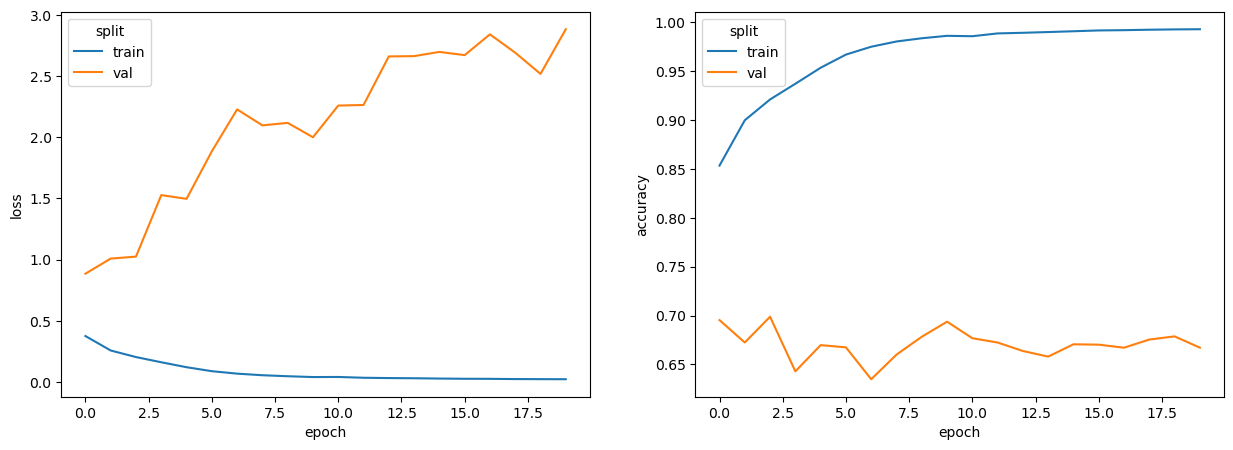

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.set_size_inches(15, 5)

sns.lineplot(data=history_df, x="epoch", y="loss", hue="split", ax=ax1)
sns.lineplot(data=history_df, x="epoch", y="accuracy", hue="split", ax=ax2)

### Data Loading

In [8]:
label_mapper = LabelMapper({
    0:0, # 0 is the label for benign (BY)
    1:0, 
    2:0,
    3:1, # 1 is the label for atypical (AT)
    4:1,
    5:2, # 2 is the label for malignant (MT)
    6:2,
})

In [9]:
class RoIDataset(ImageFolder):

    def __getitem__(self, index: int):
        x,y = super().__getitem__(index)
        path = self.imgs[index][0]
        return path, x, y

In [10]:
dataset = RoIDataset(
    root=TEST_DIR,
    target_transform=label_mapper,
    transform=Compose([
        ToTensor()
    ]),
)

In [11]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

### Prediciting

In [12]:
def predict(
    model : nn.Module,
    dataloader : DataLoader
) -> tuple[pd.DataFrame, list[str]]:
    
    Y = []
    paths = []
    labels = []
    acc = 0

    model.eval()
    
    with torch.no_grad():
        
        for path,x,y in tqdm(dataloader):

            x,y = x.to(device),y.to(device)

            y_hat = model(x)
            y_hat = torch.nn.functional.softmax(y_hat, dim=1)

            acc += torchmetrics.functional.accuracy(y_hat, y, task='multiclass',num_classes=3)

            Y.append(y_hat.cpu())
            paths.extend(path)
            labels.extend(y.cpu().tolist())

    return paths,torch.vstack(Y),labels

In [13]:
paths,y_hat,y = predict(model, loader)

  0%|          | 0/78 [00:00<?, ?it/s]

In [14]:
def get_roi_name(patch_name : str) -> str:
    name, ext = os.path.splitext(patch_name)
    roi_name = '_'.join(name.split('_')[:-1])
    return roi_name + ext

In [15]:
def create_df(paths : list[str],labels : list[int], y_hat : torch.Tensor) -> pd.DataFrame:

    df = pd.DataFrame()
    df["patch_name"] = [os.path.basename(path) for path in paths]
    df["label"] = labels

    df["roi"] = df["patch_name"].apply(get_roi_name)

    df["benign"] = y_hat[:,0].tolist()
    df["atypical"] = y_hat[:,1].tolist()
    df["malignant"] = y_hat[:,2].tolist()

    df['predicted_label'] = torch.argmax(y_hat, dim=1).tolist()

    return df

In [16]:
df = create_df(paths,y, y_hat)

In [17]:
df.head()

,patch_name,label,roi,benign,atypical,malignant,predicted_label
0,BRACS_1286_N_40_0.png,0,BRACS_1286_N_40.png,7.692118e-04,1.030214e-05,0.999220,2
1,BRACS_1286_N_40_1.png,0,BRACS_1286_N_40.png,4.600537e-05,9.786291e-05,0.999856,2
2,BRACS_1286_N_40_10.png,0,BRACS_1286_N_40.png,2.094327e-09,1.795804e-23,1.000000,2
3,BRACS_1286_N_40_11.png,0,BRACS_1286_N_40.png,1.060782e-03,3.578726e-10,0.998939,2
4,BRACS_1286_N_40_12.png,0,BRACS_1286_N_40.png,1.351499e-09,8.965438e-06,0.999991,2


### Predictions analysis (patches persepective)

In [18]:
def make_metric(metric,**kwargs): 

    def _metric(y, y_hat):
        kwargs["y_true"] = y
        kwargs["y_pred"] = y_hat
        return metric(**kwargs)
    
    return _metric

In [19]:
metrics= {
    "accuracy" : accuracy_score,
    "precision_macro" : make_metric(precision_score, average="macro"),
    "precision_micro" : make_metric(precision_score, average="micro"),
    "recall_macro" : make_metric(recall_score, average="macro"),
    "recall_micro" : make_metric(recall_score, average="micro"),
    "f1_macro" : make_metric(f1_score, average="macro"),
    "f1_micro" : make_metric(f1_score, average="micro")
}

In [20]:
def compute_metrics(
    metrics : dict, 
    y : np.ndarray, 
    y_hat : np.ndarray
) -> pd.Series:

    results = {}

    for name, metric in metrics.items():
        results[name] = metric(y, y_hat)

    return pd.Series(results)

In [21]:
compute_metrics(metrics, df["label"], df["predicted_label"])

accuracy           0.581620
precision_macro    0.493612
precision_micro    0.581620
recall_macro       0.461185
recall_micro       0.581620
f1_macro           0.461176
f1_micro           0.581620
dtype: float64

<Axes: >

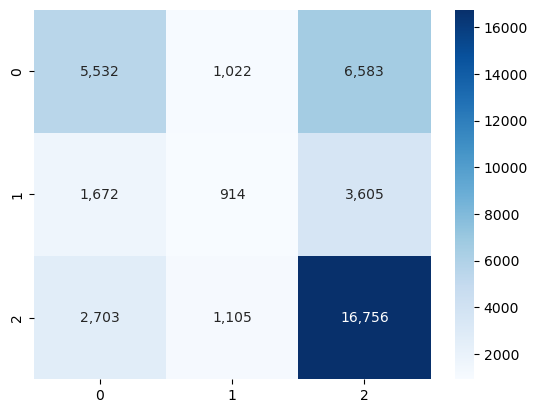

In [22]:
cm = confusion_matrix(df["label"], df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, softvoting)

In [23]:
soft_df = df[["label","roi","benign","atypical","malignant"]] \
    .groupby(by=["label","roi"]) \
    .mean() \
    .reset_index()

In [24]:
soft_df.head()

,label,roi,benign,atypical,malignant
0,0,BRACS_1228_UDH_2.png,0.000774,0.679555,0.319671
1,0,BRACS_1284_UDH_4.png,0.714431,0.055350,0.230219
2,0,BRACS_1286_N_40.png,0.246543,0.007680,0.745777
3,0,BRACS_1286_PB_21.png,0.363555,0.037063,0.599383
4,0,BRACS_1286_PB_5.png,0.320037,0.010887,0.669076


In [25]:
soft_df["predicted_label"] = np.argmax(soft_df[['benign','atypical','malignant']].values, axis=1)

In [26]:
soft_df.head()

,label,roi,benign,atypical,malignant,predicted_label
0,0,BRACS_1228_UDH_2.png,0.000774,0.679555,0.319671,1
1,0,BRACS_1284_UDH_4.png,0.714431,0.055350,0.230219,0
2,0,BRACS_1286_N_40.png,0.246543,0.007680,0.745777,2
3,0,BRACS_1286_PB_21.png,0.363555,0.037063,0.599383,2
4,0,BRACS_1286_PB_5.png,0.320037,0.010887,0.669076,2


In [27]:
compute_metrics(metrics, soft_df["label"], soft_df["predicted_label"])

accuracy           0.466667
precision_macro    0.548425
precision_micro    0.466667
recall_macro       0.474241
recall_micro       0.466667
f1_macro           0.401247
f1_micro           0.466667
dtype: float64

<Axes: >

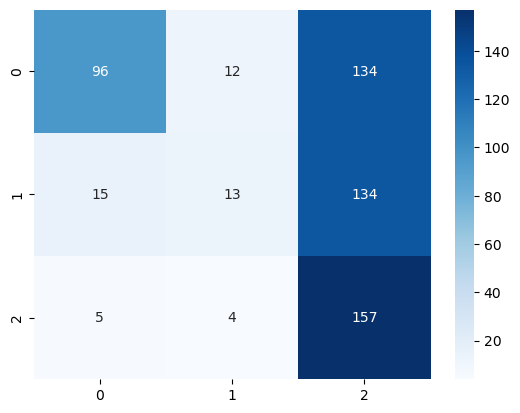

In [28]:
cm = confusion_matrix(soft_df["label"], soft_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, hardvoting)

In [29]:
def count(x:np.ndarray) -> float:
    values, counts = np.unique(x, return_counts=True)
    return values[counts.argmax()]


In [30]:
hard_df = df[["label","roi","predicted_label"]] \
    .groupby(by=["label","roi"]) \
    .agg(count) \
    .reset_index()

In [31]:
hard_df.head()

,label,roi,predicted_label
0,0,BRACS_1228_UDH_2.png,1
1,0,BRACS_1284_UDH_4.png,0
2,0,BRACS_1286_N_40.png,2
3,0,BRACS_1286_PB_21.png,2
4,0,BRACS_1286_PB_5.png,2


In [32]:
compute_metrics(metrics, hard_df["label"], hard_df["predicted_label"])

accuracy           0.464912
precision_macro    0.535524
precision_micro    0.464912
recall_macro       0.471553
recall_micro       0.464912
f1_macro           0.397613
f1_micro           0.464912
dtype: float64

<Axes: >

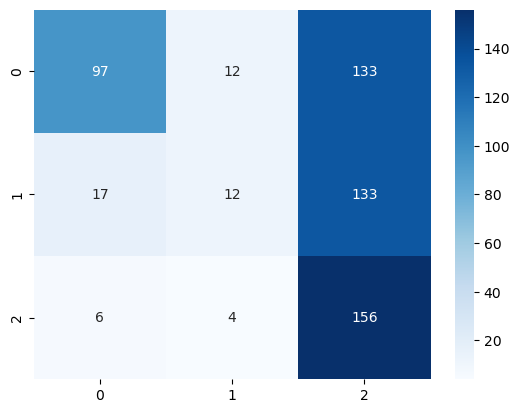

In [33]:
cm = confusion_matrix(hard_df["label"], hard_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')